# Sentiment Analysis Module

# Data Loading

## Data Formatting

In [ ]:
reviews_file = '/kaggle/input/social-recommendation-data/lthing_data/lthing_data/reviews.txt'

In [ ]:
import ast
import pandas as pd

# Initialize an empty list to store review data
data = []

with open(reviews_file, 'r') as file:
    for line in file:
        if line.strip().startswith("reviews["):  # Skip lines assigning 'reviews'
            key_value = line.strip().split(" = ", 1)[1]  # Extract dictionary part
            review_entry = ast.literal_eval(key_value)
            data.append(review_entry)

# Convert the list of dictionaries directly into a DataFrame
reviews_df = pd.DataFrame(data)

# Display the first few rows of the DataFrame
print(reviews_df.head())

                                             comment  nhelpful      unixtime  \
0  Every evening, the brave queen of Persia, Shah...         0  1.332288e+09   
1  Its the 1983-84 school year and Edward Zanni o...         0  1.253405e+09   
2  I became privy to this book, when another auth...         0  1.299888e+09   
3                                              .             0  1.327277e+09   
4  This is a tremendous story of a freed woman an...         0  1.329005e+09   

       work flags              user  stars          time  
0     73960    []  Elizabeth.Wong98    4.5  Mar 21, 2012  
1     69413    []            rivkat    3.0  Sep 20, 2009  
2   9523995    []      suz.haugland    4.0  Mar 12, 2011  
3    368228    []        amoskovacs    4.0  Jan 23, 2012  
4  11243828    []            CandyH    4.0  Feb 12, 2012  


In [ ]:
#reviews_df
reviews_df.info()
summary = pd.DataFrame({
    "Null Count": reviews_df.isnull().sum(),
    "Unique Values": reviews_df.drop(columns=['flags']).nunique()
})
print(summary)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1707070 entries, 0 to 1707069
Data columns (total 8 columns):
 #   Column    Dtype  
---  ------    -----  
 0   comment   object 
 1   nhelpful  int64  
 2   unixtime  float64
 3   work      object 
 4   flags     object 
 5   user      object 
 6   stars     float64
 7   time      object 
dtypes: float64(2), int64(1), object(5)
memory usage: 104.2+ MB
          Null Count  Unique Values
comment            0      1652363.0
flags              0            NaN
nhelpful           0           83.0
stars         319861           10.0
time              90         2921.0
unixtime          90         2921.0
user               0        83195.0
work               0       506165.0


In [ ]:
reviews_df.to_csv('/kaggle/working/reviews_df.csv')

# Data preprocessing

#### remove 'not_a_review' flags

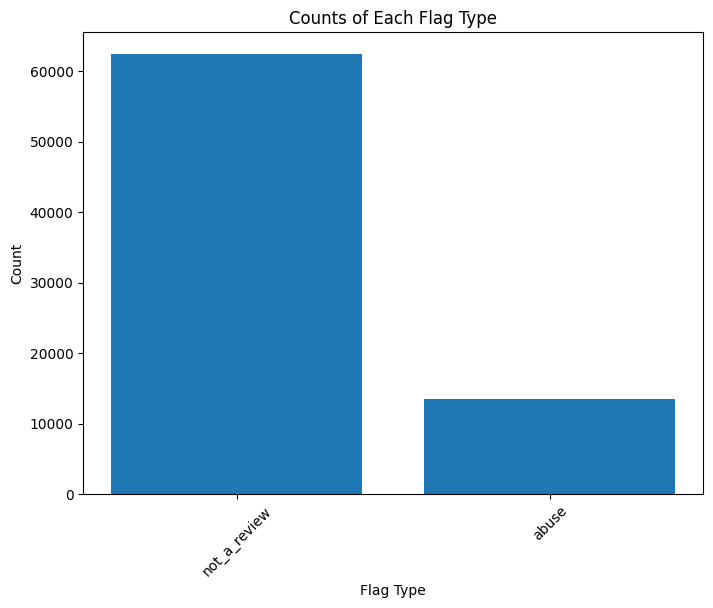

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Step 1: Flatten all lists into a single list of flags
all_flags = [flag for sublist in reviews_df['flags'] for flag in sublist]

# Step 2: Count occurrences of each flag
flag_counts = Counter(all_flags)

flag_counts_df = pd.DataFrame(list(flag_counts.items()), columns=['Flag', 'Count']).sort_values(by='Count', ascending=False)

# Step 3: Plot the counts
plt.figure(figsize=(8, 6))
plt.bar(flag_counts_df['Flag'], flag_counts_df['Count'])
plt.title('Counts of Each Flag Type')
plt.xlabel('Flag Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Filter rows where 'flag' contains 'not_a_review' and 'rating' is NaN
count = reviews_df[reviews_df['flags'].apply(lambda x: 'not_a_review' in x) & reviews_df['stars'].isna()].shape[0]

print(f"Number of rows with flag as 'not_a_review' and rating as NaN: {count}")

filtered_reviews_df = reviews_df[~(reviews_df['flags'].apply(lambda x: 'not_a_review' in x) & reviews_df['stars'].isna())].copy()
filtered_reviews_df.reset_index(drop=True, inplace=True)
filtered_reviews_df.info()

Number of rows with flag as 'not_a_review' and rating as NaN: 42644
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1664426 entries, 0 to 1664425
Data columns (total 8 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   comment   1664426 non-null  object 
 1   nhelpful  1664426 non-null  int64  
 2   unixtime  1664338 non-null  float64
 3   work      1664426 non-null  object 
 4   flags     1664426 non-null  object 
 5   user      1664426 non-null  object 
 6   stars     1387209 non-null  float64
 7   time      1664338 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 101.6+ MB


In [ ]:
# Drop unwanted columns
filtered_reviews_df.drop(columns=['unixtime', 'nhelpful', 'flags'], inplace=True)

# Verify the columns have been dropped
filtered_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1664426 entries, 0 to 1664425
Data columns (total 5 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   comment  1664426 non-null  object 
 1   work     1664426 non-null  object 
 2   user     1664426 non-null  object 
 3   stars    1387209 non-null  float64
 4   time     1664338 non-null  object 
dtypes: float64(1), object(4)
memory usage: 63.5+ MB


#### Text preprocesing

source -
* https://medium.com/@maleeshadesilva21/preprocessing-steps-for-natural-language-processing-nlp-a-beginners-guide-d6d9bf7689c9


In [ ]:
comment_df = filtered_reviews_df[['comment']].copy()
comment_df.info()

# 1 Text cleaning

# 1.1 to lowercase
print('1.1')
comment_df['comment'] = comment_df['comment'].str.lower()

# 1.2 remove URLs
print('1.2')
comment_df['clean_comment'] = comment_df['comment'].str.replace(r'https?://\S+', '', regex=True)

print('1.3')
comment_df['clean_comment'] = comment_df['clean_comment'].str.replace(r'[^\w\s]', '', regex=True).str.replace(r'\d', '', regex=True)

In [ ]:
# Count the number of empty lists in 'clean_comment'
empty_count = comment_df['clean_comment'].apply(lambda x: len(x) == 0).sum()
print(f"Number of rows with empty lists: {empty_count}")

# Remove rows with empty lists in 'clean_comment'
comment_df = comment_df[comment_df['clean_comment'].apply(lambda x: len(x) > 0)]

# Verify the shape of the DataFrame after removal
print(f"Number of rows after removal: {comment_df.shape[0]}")

comment_df.to_csv('short_clean_comments_df.csv', index=False)

## Getting book metadata

In [ ]:
import pandas as pd
import requests
import xml.etree.ElementTree as ET

# Step 1: Sample DataFrame with work IDs

df = pd.read_csv('/kaggle/input/short-clean-comments/short_clean_comments_df.csv')

# Step 2: Extract unique work IDs
unique_work_ids = df["work"].unique()
print(f"Number of unique work ids: {len(unique_work_ids)}")

# Step 3: Function to parse API response
def parse_response(work_id, xml_content):
    try:
        root = ET.fromstring(xml_content)
        title = root.find(".//title").text if root.find(".//title") is not None else "N/A"
        author = root.find(".//author").text if root.find(".//author") is not None else "N/A"
        return {"Work ID": work_id, "Title": title, "Author": author}
    except Exception as e:
        print(f"Error parsing response for Work ID {work_id}: {e}")
        return {"Work ID": work_id, "Title": "Error", "Author": "Error"}

# Step 4: Fetch data from LibraryThing API and collect in a new DataFrame
API_KEY = "2b24e0fc80db4b33f14e8b0144e0c936"
base_url = "https://www.librarything.com/services/rest/1.1/"
results = []

for i, work_id in enumerate(unique_work_ids):
    params = {
        "method": "librarything.ck.getwork",
        "id": work_id,
        "apikey": API_KEY
    }
    response = requests.get(base_url, params=params)

    if response.status_code == 200:
        book_details = parse_response(work_id, response.content)
        results.append(book_details)
    else:
        print(f"Failed to fetch data for Work ID {work_id}")
        results.append({"Work ID": work_id, "Title": "Error", "Author": "Error"})

    # Print progress every 1000 IDs
    if (i + 1) % 1000 == 0:
        print(f"Processed {i + 1}/{len(unique_work_ids)} work IDs...")

# Step 5: Create a new DataFrame with the results
results_df = pd.DataFrame(results)

# Save the results to a CSV file
results_df.to_csv("book_details.csv", index=False)

# Print the DataFrame
print(results_df)